In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys,os
import trimesh
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import spsolve

RES_PATH = './meshes/'
CURVATURES_PATH = './meshes/curvatures/'
DECOMPOSITION_PATH = './meshes/decomposition/'
SMOOTHING_PATH = './meshes/smoothing/'

### Loading all the meshes

In [12]:
mesh_bcube = os.path.join(RES_PATH,'bumpy-cube.obj')
assert os.path.exists(mesh_bcube), 'cannot found:' + mesh_bcube
bcube = trimesh.load_mesh(mesh_bcube)

mesh_cube = os.path.join(RES_PATH,'cube.obj')
assert os.path.exists(mesh_cube), 'cannot found:' + mesh_cube
cube = trimesh.load_mesh(mesh_cube)

mesh_camel = os.path.join(RES_PATH,'camel.obj')
assert os.path.exists(mesh_camel), 'cannot found:' + mesh_camel
camel = trimesh.load_mesh(mesh_camel)

mesh_armadillo = os.path.join(DECOMPOSITION_PATH,'armadillo.obj')
assert os.path.exists(mesh_armadillo), 'cannot found:' + mesh_armadillo
armadillo = trimesh.load_mesh(mesh_armadillo)

mesh_lilium = os.path.join(CURVATURES_PATH,'lilium_s.obj')
assert os.path.exists(mesh_lilium), 'cannot found:' + mesh_lilium
lilium = trimesh.load_mesh(mesh_lilium)

mesh_plane = os.path.join(CURVATURES_PATH,'plane.obj')
assert os.path.exists(mesh_plane), 'cannot found:' + mesh_plane
plane = trimesh.load_mesh(mesh_plane)

mesh_planens = os.path.join(SMOOTHING_PATH,'plane_ns.obj')
assert os.path.exists(mesh_planens), 'cannot found:' + mesh_planens
plane_ns = trimesh.load_mesh(mesh_planens)

mesh_fandiskns = os.path.join(SMOOTHING_PATH,'fandisk_ns.obj')
assert os.path.exists(mesh_fandiskns), 'cannot found:' + mesh_fandiskns
fandisk_ns = trimesh.load_mesh(mesh_fandiskns)

## Task 1: Discrete Curvature and Spectral Meshes

Given a triangle mesh, compute mean curvature (H) and Gaussian curvature (K) at each vertex. Several approximations exist to the continuous mean curvature; they differ in how they weigh the influence of the neighborhood of the vertices.

### 1. Uniform Laplace

Compute using the Laplace operator and uniform discretization the
mean curvature H (as ∆x/2) at each vertex.

In [13]:
def UniformLaplacian(mesh):
    V = mesh.vertices
    n = V.shape[0]
    
    # 使用CSR格式构建稀疏矩阵的初始数据
    rows = []
    cols = []
    data = []
    
    for i in range(V.shape[0]):
        # 对角线元素设置为-1
        rows.append(i)
        cols.append(i)
        data.append(-1)
        
        # 获取邻居
        neighbors = mesh.vertex_neighbors[i]
        
        # 邻居元素设置为 1 / 邻居数量
        val = 1 / len(neighbors)
        for neighbor in neighbors:
            rows.append(i)
            cols.append(neighbor)
            data.append(val)
    
    # 使用CSR格式的数据构建CSR格式的稀疏矩阵
    L = csr_matrix((data, (rows, cols)), shape=(n, n))
        
    return L

### Curvature Colorbar

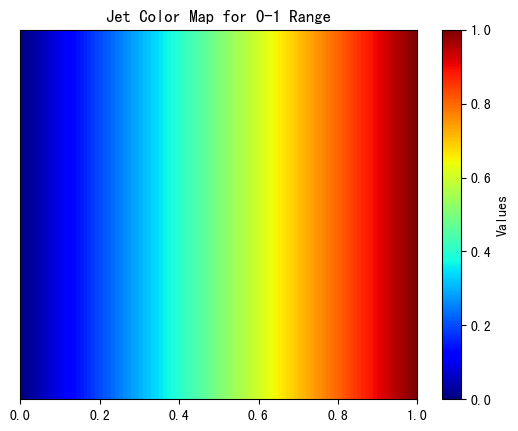

In [4]:
# 创建一个0到1的线性空间数组
x = np.linspace(0, 1, 100)
# 使用jet颜色映射将数组映射为颜色
colors = plt.cm.jet(x)

# 创建一个图像
fig, ax = plt.subplots()

# 绘制颜色条
cax = ax.imshow([x], aspect='auto', cmap='jet', extent=[0, 1, 0, 1])
ax.set_yticks([])
ax.set_title('Jet Color Map for 0-1 Range')

# 添加颜色条
cbar = plt.colorbar(cax, ax=ax, label='Values')

plt.show()

### Mean Curvature

In [5]:
def MeanCurvature(L, mesh):
    # Applying the Laplacian to the mesh
    L_mesh = L @ mesh.vertices

    # Compute the mean curvature
    H = np.linalg.norm(L_mesh, axis=1) / 2
    
    return H

In [14]:
# Choose a mesh
mesh = bcube

# Calculate mean curvature
L = UniformLaplacian(mesh)
H = MeanCurvature(L, mesh)

# Visualize mean curvature on the meash
colored_mesh = mesh.copy()
# Normalize the mean curvature
H_normalized = (H - H.min()) / (H.max() - H.min())
# RGBA
colored_mesh.visual.vertex_colors = trimesh.visual.interpolate(H_normalized, color_map='jet')
colored_mesh.export('./results/curvatures/mean_curvature.obj')

# Show the mesh
scene = trimesh.Scene(colored_mesh)
scene.show()

### Gaussian Curvature

In [8]:
def triangle_area(v1, v2, v3):
    edge1 = v2 - v1
    edge2 = v3 - v1
    # Calculate area by cross product
    cross_product = np.cross(edge1, edge2)
    area = np.linalg.norm(cross_product) / 2
    return area

In [9]:
def GaussianCurvature(mesh):
    V = mesh.vertices
    n = V.shape[0]
    F = mesh.faces
    
    K = np.zeros(n)
    
    # Iterate over all vertices
    for i in range(n):
        sumTheta = 0
        A_i = 0

        # Get faces
        faces = mesh.vertex_faces[i]
        faces = faces[faces != -1]
        
        # Iterate over all faces
        for face in faces:
            # Get points
            points = F[face]
            p1, p2 = points[points != i]

            # Compute theta angle
            v1 = V[i] - V[p1]
            v2 = V[i] - V[p2]

            sumTheta += np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            A_i += triangle_area(V[i], V[p1], V[p2])

        
        # Compute Gaussian curvature
        A_i /= 3
        K[i] = (2 * np.pi - sumTheta) / A_i
        
    return K


In [15]:
# Choose a mesh
mesh = bcube

# Calculate Gaussian curvature
K = GaussianCurvature(mesh)

# Visualize Gaussian curvature on the meash
colored_mesh = mesh.copy()
# Normalize the Gaussian curvature
K_normalized = (K - K.min()) / (K.max() - K.min())
# RGBA
colored_mesh.visual.vertex_colors = trimesh.visual.interpolate(K_normalized, color_map='jet')
colored_mesh.export('./results/curvatures/Gaussian_curvature.obj')
# Show the mesh
scene = trimesh.Scene(colored_mesh)
scene.show()

In [217]:
# # 可视化曲率
# def visualize_curvature(vertices, H, K):
#     fig = plt.figure(figsize=(12, 6))

#     # 可视化均质曲率H
#     ax1 = fig.add_subplot(121, projection='3d')
#     ax1.set_title("Mean Curvature H")
#     scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H, cmap='jet')
#     fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)

#     # 可视化高斯曲率K
#     ax2 = fig.add_subplot(122, projection='3d')
#     ax2.set_title("Gaussian Curvature K")
#     scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=K, cmap='jet')
#     fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)

#     plt.show()
# visualize_curvature(mesh.vertices, H, K)

### 2. First and Second Fundamental forms

In [16]:
# Set parameters for ellipsoid
a = 1
b = 2
c = 3

def p_ellipsoid(u, v):
    # Coordinate function of the ellipsoid
    x = a * np.cos(u) * np.sin(v)
    y = b * np.sin(u) * np.sin(v)
    z = c * np.cos(v)
    return x, y, z

In [17]:
def J_ellipsoid(u, v):
    # First order differentiation of the coordinate function
    x_u = np.array([
        -a * np.sin(u) * np.sin(v),
        b * np.cos(u) * np.sin(v),
        0
    ])
    x_v = np.array([
        a * np.cos(u) * np.cos(v),
        b * np.sin(u) * np.cos(v),
        -c * np.sin(v)
    ])
    return x_u, x_v

def H_ellipsoid(u, v):
    # Second order differentiation of the coordinate function
    x_uu = np.array([
        -a * np.cos(u) * np.sin(v),
        -b * np.sin(u) * np.sin(v),
        0
    ])
    x_uv = np.array([
        -a * np.sin(u) * np.cos(v),
        b * np.cos(u) * np.cos(v),
        0
    ])
    x_vv = np.array([
        -a * np.cos(u) * np.sin(v),
        -b * np.sin(u) * np.sin(v),
        -c * np.cos(v)
    ])
    return x_uu, x_uv, x_vv

def n_ellipsoid(u, v):
    # Normal vector of a specific point on the ellipsoid
    x_u, x_v = J_ellipsoid(u, v)
    n = np.cross(x_u, x_v)
    return n / np.linalg.norm(n)

def I_ellipsoid(u, v):
    # The first fundamental form of a specific point on the ellipsoid
    x_u, x_v = J_ellipsoid(u, v)
    E = x_u @ x_u
    F = x_u @ x_v
    G = x_v @ x_v
    return E, F, G

def II_ellipsoid(u, v):
    # The Second fundamental form of a specific point on the ellipsoid
    x_uu, x_uv, x_vv = H_ellipsoid(u, v)
    n = n_ellipsoid(u, v)
    e = x_uu @ n
    f = x_uv @ n
    g = x_vv @ n
    return e, f, g

In [18]:
def curvature_ellipsoid_at_uv(u_t, v_t):
    
    # The value of u, v on the point (a, 0, 0)
    u = 0
    v = np.pi / 2

    E, F, G = I_ellipsoid(u, v)
    e, f, g = II_ellipsoid(u, v)

    k_n = (e*u_t**2 + 2*f*u_t*v_t + g*v_t**2) / (E*u_t**2 + 2*F*u_t*v_t + G*v_t**2)

    return k_n

In [244]:
# u = 0
# v = np.pi / 2
# x_u, x_v = J_ellipsoid(u, v)
# x_u*x_v

array([-0.,  0., -0.])

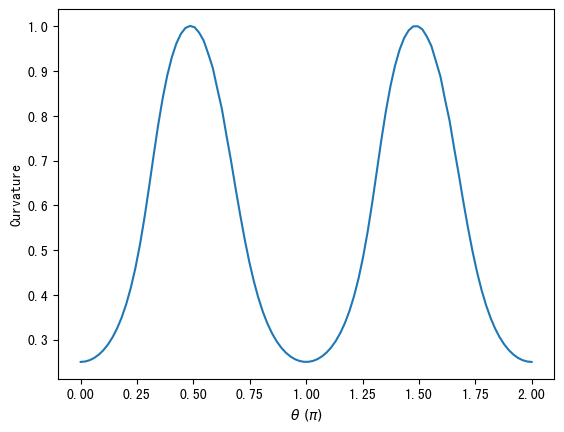

In [19]:
# t can be arbitrary direction
thetas = np.linspace(0, 2 * np.pi, 100)
curvatures = []
for theta in thetas:
    u_t = np.cos(theta)
    v_t = np.sin(theta)
    c = curvature_ellipsoid_at_uv(u_t, v_t)
    curvatures.append(c)
plt.ylabel('Curvature')
plt.xlabel('$\\theta \\ (\pi)$')
plt.plot(thetas / np.pi, curvatures)

### 3. Non-uniform (Discrete Laplace-Beltrami)

In [20]:
def DiscreteLaplaceBeltrami(mesh):
    V = mesh.vertices
    F = mesh.faces
    n = V.shape[0]

    # Define the sparse matrix for C and M^-1
    C_data = []
    C_row = []
    C_col = []
    M_inv_data = []
    M_inv_row = []
    M_inv_col = []

    # Iterate over all vertices
    for i in range(n):
        A_i = 0
        # Get faces
        faces = mesh.vertex_faces[i]
        faces = faces[faces != -1]

        # Find the start face
        # Determine the start face in the scenario where the faces do not cover all around the vertex
        d = {}
        for face in faces:
            points = F[face]
            for p in points:
                if p not in d:
                    d[p] = 1
                else:
                    d[p] += 1
        
        flag = True

        # Find the start face for this scenario as being a face that only has one neighbouring face
        for key in d:
            if d[key] == 1:
                start_face = [f for f in faces if key in F[f]][0]
                flag = False
                break

        # If we are not in this scenario, then we can just take the first face
        if flag:
            start_face = faces[0]
        
        # Starting with the find face, create a list of the faces in order
        # Meaning that they have a common edge
        my_faces = [start_face]
        cface = start_face

        # Set that has the faces that we have not yet added to the list
        set_faces = faces.tolist()
        set_faces.remove(cface)

        # While we have not added all faces to the list
        while len(set_faces) > 0:
            # Iterate over all faces
            for j in range(len(set_faces)):
                # Get the face's vertices
                f = F[set_faces[j]]
                # Find the common vertices with the current face
                common_points = [p for p in f if p in F[cface]]
                # If there are two common vertices, then we have found the next face
                if len(common_points) == 2:
                    cface = set_faces[j]
                    set_faces.remove(cface)
                    my_faces.append(cface)
                    break

        cotan_sum = 0
        for j in range(len(my_faces)):
            # Get the current and next face
            face = my_faces[j]
            face_after = my_faces[(j + 1) % len(my_faces)]

            # Get the points
            points = F[face]
            points_after = F[face_after]

            ps = points[points != i]
            ps_after = points_after[points_after != i]

            err = False

            # Determine which points are in common
            # p1 is the previous vertex, p2 is the j vertex that creates a common edge with the current vertex
            # p3 is the next vertex
            if ps[1] == ps_after[0]:
                p1 = ps[0]
                p2 = ps[1]
                p3 = ps_after[1]
            elif ps[1] == ps_after[1]:
                p1 = ps[0]
                p2 = ps[1]
                p3 = ps_after[0]
            elif ps[0] == ps_after[0]:
                p1 = ps[1]
                p2 = ps[0]
                p3 = ps_after[1]
            elif ps[0] == ps_after[1]:
                p1 = ps[1]
                p2 = ps[0]
                p3 = ps_after[0]
            else:
                err = True

            # Check for potential errors
            if not err:
                # Compute the edges
                v11 = V[p1] - V[i]
                v12 = V[p1] - V[p2]
                v21 = V[p3] - V[i]
                v22 = V[p3] - V[p2]
                
                # Compute the alpha and beta angles
                alpha = np.arccos(np.dot(v11, v12) / (np.linalg.norm(v11) * np.linalg.norm(v12)))
                beta = np.arccos(np.dot(v21, v22) / (np.linalg.norm(v21) * np.linalg.norm(v22)))

                # Compute the cotan sum
                cotan_sum += (1 / np.tan(alpha)) + (1 / np.tan(beta))

                # Add the data to the sparse matrix
                C_data.append((1 / np.tan(alpha)) + (1 / np.tan(beta)))
                C_row.append(i)
                C_col.append(p2)
            
            # Compute the area
            A_i += triangle_area(V[i], V[p1], V[p2])

        # Add the data to the sparse matrix
        C_data.append(-cotan_sum)
        C_row.append(i)
        C_col.append(i)
        M_inv_data.append(1 / (2 * A_i))
        M_inv_row.append(i)
        M_inv_col.append(i)

    # Create the sparse matrices
    C = csr_matrix((C_data, (C_row, C_col)), shape=(n, n))
    M_inv = csr_matrix((M_inv_data, (M_inv_row, M_inv_col)), shape=(n, n))

    # Compute the discrete Laplace-Beltrami operator
    L = M_inv @ C

    return L

In [22]:
# Choose a mesh
# mesh = lilium
mesh = plane

# Calculate mean curvature based on Discrete Laplace-Beltrami
DLB = DiscreteLaplaceBeltrami(mesh)
H = MeanCurvature(DLB, mesh)

# Visualize mean curvature on the meash
colored_mesh = mesh.copy()
# Normalize the mean curvature
H_normalized = (H - H.min()) / (H.max() - H.min())
# RGBA
colored_mesh.visual.vertex_colors = trimesh.visual.interpolate(H_normalized, color_map='jet')
colored_mesh.export('./results/curvatures/mean_curvature_DLB.obj')

# Show the mesh
scene = trimesh.Scene(colored_mesh)
scene.show()

### 4. Modal analysis

In [23]:
def spectralAnalysis(mesh, L, k):
    # Compute the eigenvectors and eigenvalues of the Laplace-Beltrami operator
    _, e = eigs(L, k, which='SM')

    x = np.zeros(mesh.vertices.shape[0])
    y = np.zeros(mesh.vertices.shape[0])
    z = np.zeros(mesh.vertices.shape[0])

    # Compute the coordinates of the vertices in the new basis
    for i in range(k):
        ei = np.real(e[:, i])
        x += np.dot(mesh.vertices[:, 0], ei) * ei
        y += np.dot(mesh.vertices[:, 1], ei) * ei
        z += np.dot(mesh.vertices[:, 2], ei) * ei

    # Reconstruct the mesh
    reconstructed_mesh = type(mesh)()
    reconstructed_mesh.vertices = np.column_stack((x, y, z))
    reconstructed_mesh.faces = mesh.faces

    return reconstructed_mesh

In [24]:
DLB = DiscreteLaplaceBeltrami(armadillo)

ks = [5, 15, 50, 200]

for k in ks:
    reconstructed_mesh = spectralAnalysis(armadillo, DLB, k)
    reconstructed_mesh.export('results/reconstructions/armadillo_{}.obj'.format(k))

## TASK2: Laplacian Mesh Smoothing

### 5. explicit Laplacian mesh smoothing

In [25]:
def ExplicitSmoothing(mesh, l, max_iter=5):
    I = sp.eye(mesh.vertices.shape[0])
    res_mesh = mesh.copy()
    
    # Perform the diffusion flow
    for _ in range(max_iter):
        # Compute the discrete Laplace-Beltrami operator
        L = UniformLaplacian(res_mesh)
        res_mesh.vertices = (I + l * L) @ res_mesh.vertices
    
    return res_mesh

In [26]:
test_meshes = [cube, fandisk_ns, plane_ns]
test_names = ['cube', 'fandisk_ns', 'plane_ns']
test_iters = [5, 25, 50]
test_lambdas = [0.01, 0.1, 0.5, 1, 1.5]

# Perform the diffusion flow for each mesh and save the results
for mesh, name in zip(test_meshes, test_names):
    for l in test_lambdas:
        for iter in test_iters:
            res_mesh = ExplicitSmoothing(mesh, l, iter)
            res_mesh.export('results/smoothing/explicit/{}_{}_{}.obj'.format(name, l, iter))


### 6. implicit Laplacian mesh smoothing 

In [31]:
def MC_DiscreteLaplaceBeltrami(mesh):
    V = mesh.vertices
    F = mesh.faces
    n = V.shape[0]

    # Define the sparse matrix for C and M^-1
    C_data = []
    C_row = []
    C_col = []
    M_inv_data = []
    M_inv_row = []
    M_inv_col = []

    # Iterate over all vertices
    for i in range(n):
        A_i = 0
        # Get faces
        faces = mesh.vertex_faces[i]
        faces = faces[faces != -1]

        # Find the start face
        # Determine the start face in the scenario where the faces do not cover all around the vertex
        d = {}
        for face in faces:
            points = F[face]
            for p in points:
                if p not in d:
                    d[p] = 1
                else:
                    d[p] += 1
        
        flag = True

        # Find the start face for this scenario as being a face that only has one neighbouring face
        for key in d:
            if d[key] == 1:
                start_face = [f for f in faces if key in F[f]][0]
                flag = False
                break

        # If we are not in this scenario, then we can just take the first face
        if flag:
            start_face = faces[0]
        
        # Starting with the find face, create a list of the faces in order
        # Meaning that they have a common edge
        my_faces = [start_face]
        cface = start_face

        # Set that has the faces that we have not yet added to the list
        set_faces = faces.tolist()
        set_faces.remove(cface)

        # While we have not added all faces to the list
        while len(set_faces) > 0:
            # Iterate over all faces
            for j in range(len(set_faces)):
                # Get the face's vertices
                f = F[set_faces[j]]
                # Find the common vertices with the current face
                common_points = [p for p in f if p in F[cface]]
                # If there are two common vertices, then we have found the next face
                if len(common_points) == 2:
                    cface = set_faces[j]
                    set_faces.remove(cface)
                    my_faces.append(cface)
                    break

        cotan_sum = 0
        for j in range(len(my_faces)):
            # Get the current and next face
            face = my_faces[j]
            face_after = my_faces[(j + 1) % len(my_faces)]

            # Get the points
            points = F[face]
            points_after = F[face_after]

            ps = points[points != i]
            ps_after = points_after[points_after != i]

            err = False

            # Determine which points are in common
            # p1 is the previous vertex, p2 is the j vertex that creates a common edge with the current vertex
            # p3 is the next vertex
            if ps[1] == ps_after[0]:
                p1 = ps[0]
                p2 = ps[1]
                p3 = ps_after[1]
            elif ps[1] == ps_after[1]:
                p1 = ps[0]
                p2 = ps[1]
                p3 = ps_after[0]
            elif ps[0] == ps_after[0]:
                p1 = ps[1]
                p2 = ps[0]
                p3 = ps_after[1]
            elif ps[0] == ps_after[1]:
                p1 = ps[1]
                p2 = ps[0]
                p3 = ps_after[0]
            else:
                err = True

            # Check for potential errors
            if not err:
                # Compute the edges
                v11 = V[p1] - V[i]
                v12 = V[p1] - V[p2]
                v21 = V[p3] - V[i]
                v22 = V[p3] - V[p2]
                
                # Compute the alpha and beta angles
                alpha = np.arccos(np.dot(v11, v12) / (np.linalg.norm(v11) * np.linalg.norm(v12)))
                beta = np.arccos(np.dot(v21, v22) / (np.linalg.norm(v21) * np.linalg.norm(v22)))

                # Compute the cotan sum
                cotan_sum += (1 / np.tan(alpha)) + (1 / np.tan(beta))

                # Add the data to the sparse matrix
                C_data.append((1 / np.tan(alpha)) + (1 / np.tan(beta)))
                C_row.append(i)
                C_col.append(p2)
            
            # Compute the area
            A_i += triangle_area(V[i], V[p1], V[p2])

        # Add the data to the sparse matrix
        C_data.append(-cotan_sum)
        C_row.append(i)
        C_col.append(i)
        M_inv_data.append(1 / (2 * A_i))
        M_inv_row.append(i)
        M_inv_col.append(i)

    # Create the sparse matrices
    C = csr_matrix((C_data, (C_row, C_col)), shape=(n, n))
    M_inv = csr_matrix((M_inv_data, (M_inv_row, M_inv_col)), shape=(n, n))

    # Compute the discrete Laplace-Beltrami operator
    # L = M_inv @ C

    M_data = [1 / x for x in M_inv_data]
    M = csr_matrix((M_data, (M_inv_row, M_inv_col)), shape=(n, n))

    return M, C

In [39]:
def ImplicitSmoothing(mesh, l, max_iter=5):
    res_mesh = mesh.copy()
    # Compute the discrete Laplace-Beltrami operator
    M, C = MC_DiscreteLaplaceBeltrami(res_mesh)

    # Perform the implicit smoothing
    for _ in range(max_iter):
        # Determine A and b matrices to solve the linear system Ax = b
        A = M - l * C
        b = M @ res_mesh.vertices
        # Solve the linear system
        X = spsolve(A, b)
        # Update the vertices of the mesh
        res_mesh.vertices = X
    
    return res_mesh
    

In [40]:
test_meshes = [cube, fandisk_ns, plane_ns]
test_names = ['cube', 'fandisk_ns', 'plane_ns']
test_iters = [5, 25, 50]
test_lambdas = [0.01, 0.1, 0.5, 1, 1.5]

# Perform the implicit smoothing for each mesh and save the results
for mesh, name in zip(test_meshes, test_names):
    for l in test_lambdas:
        for iter in test_iters:
            res_mesh = ImplicitSmoothing(mesh, l, iter)
            res_mesh.export('results/smoothing/implicit/{}_{}_{}.obj'.format(name, l, iter))


### 7. Denoising

In [73]:
test_noise = [0.01, 0.05, 0.1]
test_meshes = [cube]
test_names = ['cube']
test_lambdas = [0.2]

for mesh, name in zip(test_meshes, test_names):
    for l in test_lambdas:
        for noise in test_noise:
            noisy_mesh = mesh.copy()
            # Add noise to the vertices
            noisy_mesh.vertices += np.random.normal(0, noise, noisy_mesh.vertices.shape)
            noisy_mesh.export('results/denoising/{}_{}_noise.obj'.format(name, noise))
            
            # Perform the smoothing operation
            res_mesh = ExplicitSmoothing(noisy_mesh, l)
            res_mesh.export('results/denoising/{}_{}_denoise.obj'.format(name, noise))


In [74]:
test_noise = [0.1, 0.5, 1]
test_meshes = [camel]
test_names = ['camel']
test_lambdas = [0.2]

for mesh, name in zip(test_meshes, test_names):
    for l in test_lambdas:
        for noise in test_noise:
            noisy_mesh = mesh.copy()
            # Add noise to the vertices
            noisy_mesh.vertices += np.random.normal(0, noise, noisy_mesh.vertices.shape)
            noisy_mesh.export('results/denoising/{}_{}_noise.obj'.format(name, noise))
            
            # Perform the smoothing operation
            res_mesh = ExplicitSmoothing(noisy_mesh, l)
            res_mesh.export('results/denoising/{}_{}_denoise.obj'.format(name, noise))
